In [1]:
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import pandas as pd
import numpy as np
import seaborn as sns
import os
import torch
import timm
import torchvision.transforms as transforms
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
import cv2
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import torch.nn as nn

/cluster/home/taheeraa/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Bounding boxes and XAI within Chest X-Ray14 dataset

Want to add gradcam to alexnet baseline and compare them to the bounding boxes in the dataset.

In [2]:
root_folder = '/cluster/home/taheeraa/datasets/chestxray-14/'
images_path = f"{root_folder}/images"
file_path_bbox = root_folder + 'BBox_List_2017.csv'

labels = [
        "Atelectasis", 
        "Cardiomegaly",
        "Effusion", 
        "Infiltration", 
        "Mass",
        "Nodule",
        "Pneumonia",
        "Pneumothorax",  
        "Consolidation",
        "Edema",
        "Emphysema",
        "Fibrosis",
        "Pleural_Thickening",
        "Hernia"
    ]
num_labels = len(labels) 

In [3]:
df_bbox = pd.read_csv(file_path_bbox)
file_path_data_entry = root_folder + 'Data_Entry_2017.csv'
df_data_entry = pd.read_csv(file_path_data_entry)
merged_df = pd.merge(df_bbox, df_data_entry, on='Image Index', how='inner')
merged_df.rename(columns={
    'Bbox [x': 'x',
    'h]': 'h',
}, inplace=True)
merged_df['filepath'] = '/cluster/home/taheeraa/datasets/chestxray-14/images/' + merged_df['Image Index']
df = merged_df
df.head()



,Image Index,Finding Label,x,y,w,h,Unnamed: 6,Unnamed: 7,Unnamed: 8,Finding Labels,...,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,filepath
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,NaN,NaN,NaN,Atelectasis,...,13118,69,M,PA,2992,2991,0.143,0.143,NaN,/cluster/home/taheeraa/datasets/chestxray-14/i...
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525,NaN,NaN,NaN,Atelectasis|Effusion|Mass,...,14716,53,M,AP,3056,2544,0.139,0.139,NaN,/cluster/home/taheeraa/datasets/chestxray-14/i...
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153,NaN,NaN,NaN,Atelectasis,...,29817,67,F,AP,3056,2544,0.139,0.139,NaN,/cluster/home/taheeraa/datasets/chestxray-14/i...
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034,NaN,NaN,NaN,Atelectasis|Cardiomegaly|Consolidation,...,14687,51,M,AP,2500,2048,0.168,0.168,NaN,/cluster/home/taheeraa/datasets/chestxray-14/i...
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695,NaN,NaN,NaN,Atelectasis,...,17877,75,F,AP,2500,2048,0.168,0.168,NaN,/cluster/home/taheeraa/datasets/chestxray-14/i...


## look at image index

I want to know which images has more than one bounding box related to the image

In [27]:
image_index_counts = df.groupby('Image Index').size()

# Convert to DataFrame for better handling and sort
image_index_counts_df = image_index_counts.reset_index(name='Count').sort_values(by='Count', ascending=False)
image_index_counts_df

,Image Index,Count
204,00010277_000.png,4
279,00012376_010.png,3
633,00021703_001.png,3
220,00010828_039.png,3
327,00013659_019.png,3
...,...,...
312,00013249_052.png,1
313,00013272_005.png,1
314,00013285_026.png,1
315,00013310_057.png,1


Here one can see that some images has more than one bbox related to the images

## plot bounding boxes with xrays

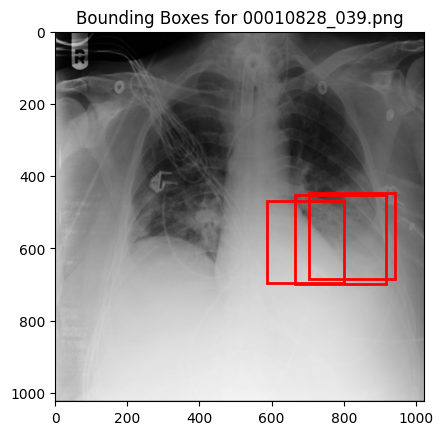

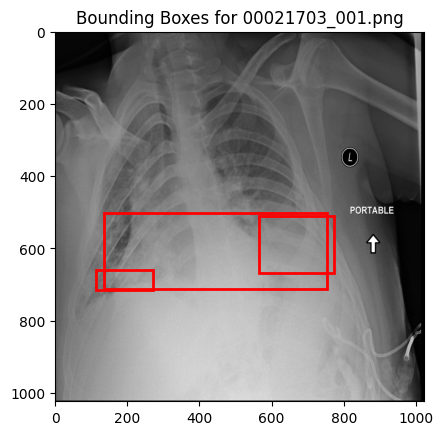

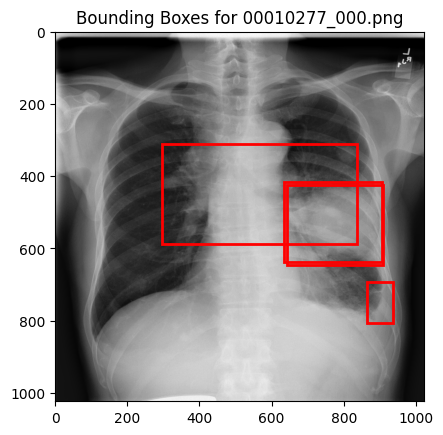

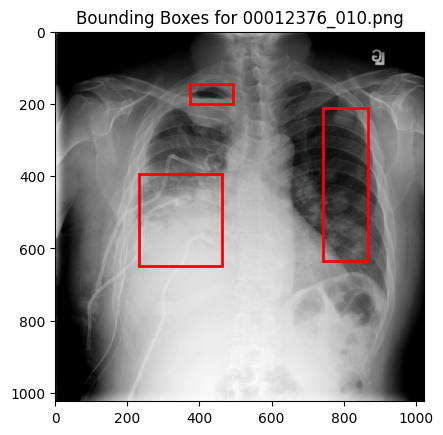

In [28]:
# Filter the DataFrame to include only those with multiple bounding boxes
multi_boxes = df[df['Image Index'].isin(['00010277_000.png', '00012376_010.png', '00021703_001.png', '00010828_039.png'])]

# Define the base path for the images
base_path = '/cluster/home/taheeraa/datasets/chestxray-14/images/'

# Loop through the unique images that have more than one bounding box
for image_index in multi_boxes['Image Index'].unique():
    # Load the image
    img_path = base_path + image_index
    img = Image.open(img_path)
    fig, ax = plt.subplots(1)
    ax.imshow(img, cmap='gray')
    
    # Get rows for the current image
    rows = multi_boxes[multi_boxes['Image Index'] == image_index]
    
    # Draw each bounding box
    for idx, row in rows.iterrows():
        # Create a rectangle patch
        rect = patches.Rectangle((row['x'], row['y']), row['w'], row['h'], linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    
    # Display the image
    plt.title(f"Bounding Boxes for {image_index}")
    plt.show()


# Inference with gradcam
00021703_001, 00005066_030, 00027441_002

In [29]:
img_id = "00010828_039"
img_index = f"{img_id}.png"
df_filtered = merged_df[merged_df['Image Index'] == img_index]
df_filtered

,Image Index,Finding Label,x,y,w,h,Unnamed: 6,Unnamed: 7,Unnamed: 8,Finding Labels,...,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,filepath
311,00010828_039.png,Effusion,702.577778,447.469045,238.933333,237.795556,NaN,NaN,NaN,Atelectasis|Consolidation|Effusion|Infiltration,...,10828,45,M,AP,2500,2048,0.168,0.168,NaN,/cluster/home/taheeraa/datasets/chestxray-14/i...
464,00010828_039.png,Infiltrate,666.168889,450.882378,250.311111,246.897778,NaN,NaN,NaN,Atelectasis|Consolidation|Effusion|Infiltration,...,10828,45,M,AP,2500,2048,0.168,0.168,NaN,/cluster/home/taheeraa/datasets/chestxray-14/i...
967,00010828_039.png,Atelectasis,588.060451,469.086823,213.902222,227.555556,NaN,NaN,NaN,Atelectasis|Consolidation|Effusion|Infiltration,...,10828,45,M,AP,2500,2048,0.168,0.168,NaN,/cluster/home/taheeraa/datasets/chestxray-14/i...


## loading model

In [30]:
base = "/cluster/home/taheeraa/code/BenchmarkTransformers/models/classification/ChestXray14/05-change-classifier-head/"
pretrained_weights = base + "densenet121_imagenet_1k_adamw_32_bce_aug_class/model.pth.tar"

experiment_name = os.path.basename(os.path.dirname(pretrained_weights))
model_str = experiment_name.split('_')[0]
print(experiment_name, model_str)

def classifying_head(in_features: int, num_labels: int):
    return nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=in_features, out_features=128),
        nn.ReLU(),
        nn.BatchNorm1d(num_features=128),
        nn.Linear(128, num_labels),
    )

if model_str =="alexnet":
    model = alexnet(weights="DEFAULT")
    model.classifier = nn.Linear(256*6*6, num_labels, bias=True)
elif model_str=="resnet50":
    model = timm.create_model(model_str, num_classes=num_labels, pretrained=True)
elif model_str == "densenet121":
    model = timm.create_model('densenet121', num_classes=num_labels, pretrained=True)
    model.classifier = classifying_head(1024, num_labels)
    
checkpoint = torch.load(pretrained_weights, map_location="cpu")
print(checkpoint.keys())
state_dict = checkpoint['state_dict']
msg = model.load_state_dict(state_dict, strict=False)
print('Loaded with msg: {}'.format(msg))

densenet121_imagenet_1k_adamw_32_bce_aug_class densenet121
dict_keys(['epoch', 'lossMIN', 'state_dict', 'optimizer', 'scheduler'])
Loaded with msg: <All keys matched successfully>


## prepare data

In [31]:
def load_and_preprocess_images(image_paths,normalize="chestx-ray"):
    if normalize.lower() == "imagenet":
        normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    elif normalize.lower() == "chestx-ray":
        normalize = transforms.Normalize([0.5056, 0.5056, 0.5056], [0.252, 0.252, 0.252])
        
    transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Resize the image to the same size expected by the model
        transforms.CenterCrop(224),
        transforms.ToTensor(),  # Convert the image to a tensor
        normalize
    ])
    images = [transform(Image.open(path).convert('RGB')) for path in image_paths]
    batch = torch.stack(images)  # Stack images into a single batch
    return batch

img_index = "00021703_001.png"

img_filenames = [f'{img_index}']
img_paths = [f"{images_path}/{filename}" for filename in img_filenames]
img_path = img_paths[0]
input_tensor = load_and_preprocess_images(img_paths)

## model inference

In [32]:
import torch

def predict(model, batch, threshold=0.2):
    model.eval()  # Ensure the model is in evaluation mode
    with torch.no_grad():  # Turn off gradients to speed up this part
        logits = model(batch)  # Forward pass
        print(logits.shape)
        probabilities = torch.sigmoid(logits)  # Convert logits to probabilities for multilabel classification
        labels = (probabilities >= threshold).int().numpy()[0]
    return labels

# Example usage:
# Perform inference
pred_labels = predict(model, input_tensor)
print(labels)
pred_idx = [idx for idx, _ in enumerate(labels) if pred_labels[idx] == 1]
print(pred_idx)
for i in range(len(pred_idx)):
    print(labels[i])

torch.Size([1, 14])
['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']
[0, 2, 3]
Atelectasis
Cardiomegaly
Effusion


## looking at xai

In [33]:
def generate_cam_images(model, input_tensor, target_layers, types_of_cam):
    cams = {
        'GradCAM': GradCAM,
        'HiResCAM': HiResCAM,
        'ScoreCAM': ScoreCAM,
        'GradCAMPlusPlus': GradCAMPlusPlus,
        'AblationCAM': AblationCAM,
        'XGradCAM': XGradCAM,
        'EigenCAM': EigenCAM,
        'FullGrad': FullGrad
    }

    images = []
    for cam_name in types_of_cam:
        cam_type = cams[cam_name]
        cam = cam_type(model=model, target_layers=target_layers)
        targets = [ClassifierOutputTarget(0)]  # Assuming you want to target class 0
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]

        # Normalize input_tensor for visualization
        img_for_vis = input_tensor.squeeze().cpu().permute(1, 2, 0).numpy()
        img_for_vis = img_for_vis - img_for_vis.min()  # Shift to have lowest value at 0
        img_for_vis = img_for_vis / img_for_vis.max()  # Scale to max value of 1

        # Create CAM image
        cam_image = show_cam_on_image(img_for_vis, grayscale_cam, use_rgb=True)
        images.append((cam_name, cam_image))

    return images

In [34]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
target_layers = [model.features.norm5]
types_of_cam = ['GradCAM', 'HiResCAM', 'ScoreCAM', 'GradCAMPlusPlus', 'AblationCAM', 'XGradCAM', 'EigenCAM', 'FullGrad']
cam_images = generate_cam_images(model, input_tensor, target_layers, types_of_cam)

100%|██████████| 32/32 [03:06<00:00,  5.82s/it]


In [50]:
cam_image_new = [cam_images[0] + cam_images[-1]]
cam_images

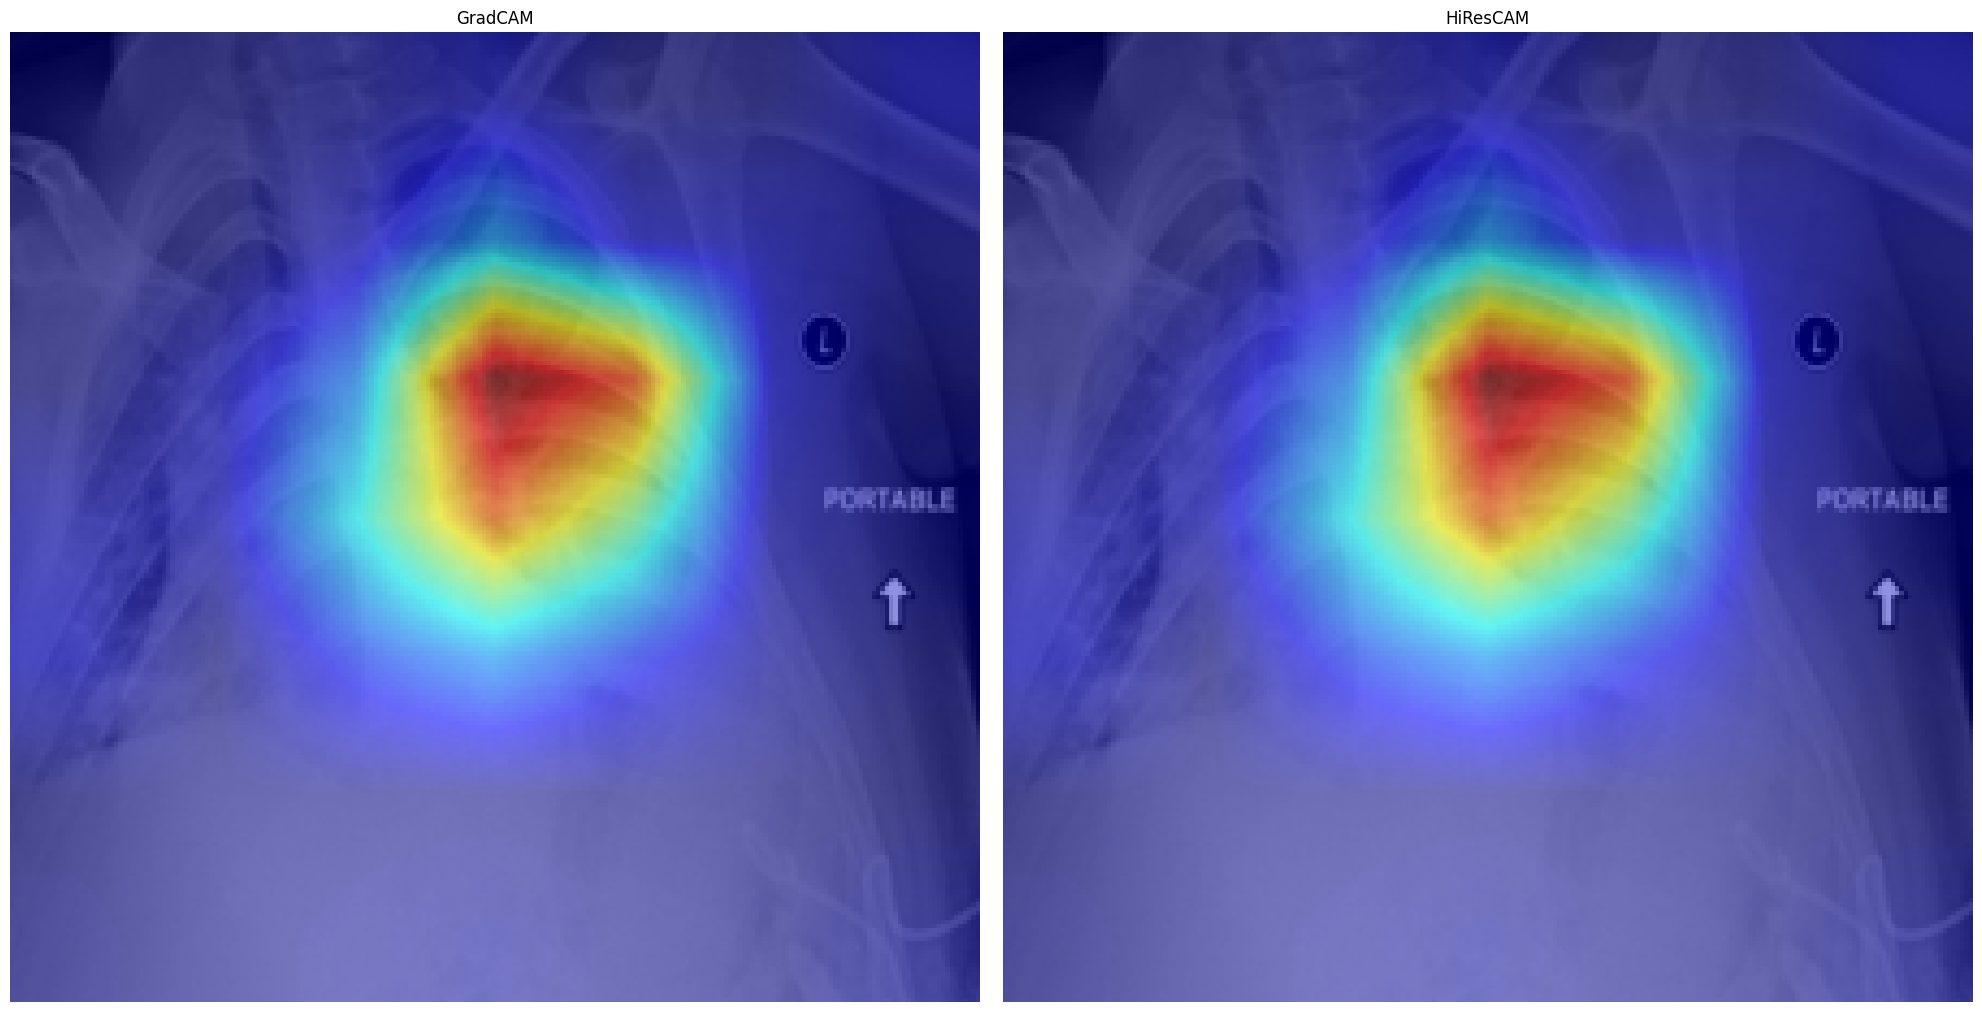

In [53]:
# Visualization of CAM images in a 2x4 grid
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))  # Adjust figsize if needed for better display
axs = axs.flatten()  # Flatten the axis array to easily iterate over it

for ax, (cam_name, image) in zip(axs, cam_images):
    ax.imshow(image)
    ax.title.set_text(cam_name)
    ax.axis('off')

# Hide any unused axes if the number of CAM types is less than 8
for i in range(len(cam_images), 2):
    axs[i].axis('off')

plt.tight_layout()
plt.savefig(f"xai/densenet/{img_id}_xai.png")

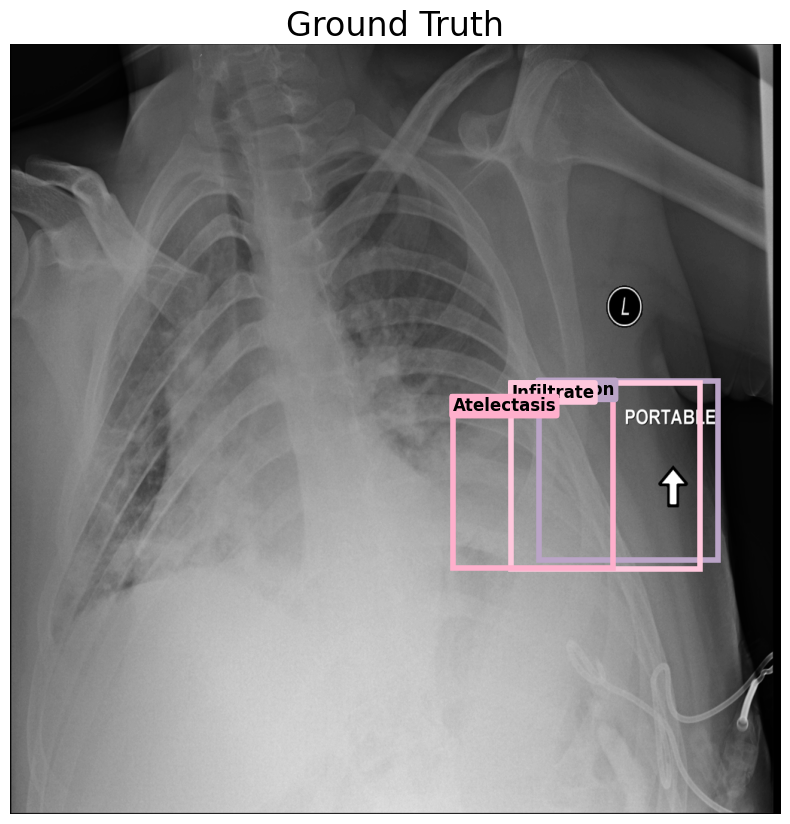

In [36]:
# Define specific colors
colors_list = ['#BAA4C7', '#FFC8DD', '#FFAFCC', '#BDE0FE']
unique_labels = df_filtered['Finding Label'].unique()
if len(unique_labels) > len(colors_list):
    print("Warning: There are more unique labels than provided colors. Some labels will have the same color.")
label_color_map = {label: colors_list[i % len(colors_list)] for i, label in enumerate(unique_labels)}

# Open the image
img = Image.open(img_path)

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 1, figsize=(20, 10))

# First subplot: Image with bounding boxes
ax1 = axs
ax1.imshow(img, cmap='gray')

# Draw each bounding box with its corresponding label
for idx, row in df_filtered.iterrows():
    x, y, w, h = row['x'], row['y'], row['w'], row['h']
    label = row['Finding Label']
    color = label_color_map[label]
    rect = patches.Rectangle((x, y), w, h, linewidth=4, edgecolor=color, facecolor='none')
    ax1.add_patch(rect)
    ax1.text(x, y, label, verticalalignment='top', color='black', fontsize=12, weight='bold', 
             bbox=dict(facecolor=color, edgecolor='none', boxstyle='round,pad=0.2'))

ax1.set_title("Ground Truth", fontsize=24)
ax1.axis('off')
plt.savefig(f"xai/densenet/{img_id}_gt.png")

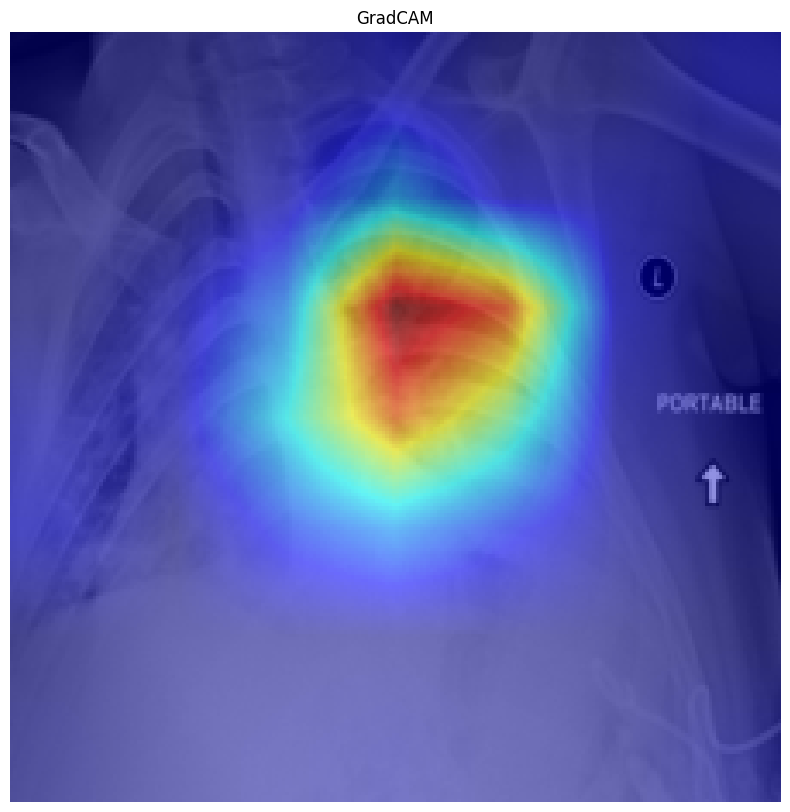

In [56]:
import matplotlib.pyplot as plt

# Assuming `cam_images` is a list of tuples as returned by your generate_cam_images function
# Extract just the GradCAM image
grad_cam_image = None
for cam_name, image in cam_images:
    if cam_name == 'GradCAM':
        grad_cam_image = image
        break

# Check if GradCAM image was found and then plot
if grad_cam_image is not None:
    plt.figure(figsize=(20, 10))  # Adjust figsize if needed for better display
    plt.imshow(grad_cam_image)
    plt.title('GradCAM')
    plt.axis('off')
    plt.savefig(f"xai/densenet/{img_id}_gradcam.png")  # Use plt.show() to display the image directly in Jupyter notebook
else:
    print("GradCAM image not found.")
